In [1]:
import GPI_init_fit as gpi
import numpy as np
import matplotlib.pyplot as plt
import statistical_analysis.interpolated_univariate_spline as spline_func
from astropy.stats import bayesian_info_criterion as bic
from astropy.stats import akaike_info_criterion as aic

/home/blewis/anaconda3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
CuPy succesfully imported. Using GPU where applicable. Set use_gpu=False to override this functionality.


## Initial Fit With Scipy Minimize 

### Model with 9 knots is preferred

In [4]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
from astropy.io import fits
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.3'
jax.config.update("jax_enable_x64", True)
import pandas as pd
from statistical_analysis.optimize_framework import Optimizer, OptimizeUtils
from utils.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from utils.SLD_ojax import ScatteredLightDisk
from utils.SLD_utils import *

In [5]:
name = 'hr4796a_H_pol'
fits_image_filepath = "/home/blewis/GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)

In [6]:
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:],bounds=(50, 230, 50, 230))
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]),bounds=(50, 230, 50, 230))
misc_params = Parameter_Index.misc_params
misc_params['nx'] = 180
misc_params['ny'] = 180 #, outlier_pixels=[(57, 68)]))

In [84]:
num_knots = 9

spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
disk_params = Parameter_Index.disk_params

image_data = pd.read_csv('statistical_analysis/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "a_in", "a_out", "eccentricity", "ksi0", "gamma", "beta", "omega", "x_center", "y_center", "knots"]
row = image_data.loc[name]

disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]
misc_params['distance'] = row["Distance"]
spf_params['num_knots'] = num_knots
spf_params['knot_values'] = jnp.full(spf_params['num_knots'],0.5)
disk_params['alpha_in'] = row['a_in']
disk_params['alpha_out'] = row['a_out']
disk_params['e'] = row['eccentricity']
disk_params['ksi0'] = row['ksi0']
disk_params['gamma'] = row['gamma']
disk_params['beta'] = row['beta']
disk_params['omega'] = row['omega']
disk_params['x_center'] = row['x_center']
disk_params['y_center'] = row['y_center']

In [85]:
opt = Optimizer(disk_params, spf_params, psf_params, misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']
opt.inc_bound_knots()
opt.scale_initial_knots(target_image)
soln = opt.scipy_optimize(fit_keys, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
optimal_image = opt.model()
optimal_ll = opt.log_likelihood(target_image,err_map)

         Current function value: 79165.559119
         Iterations: 110
         Function evaluations: 4701
         Gradient evaluations: 204
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 79165.55911873913
        x: [ 3.430e+01 -2.004e+01 ...  2.382e+00 -1.661e+01]
      nit: 110
      jac: [-1.338e-01  3.809e-02 ...  7.715e-02  0.000e+00]
 hess_inv: [[ 2.330e+00  2.203e-01 ...  8.002e-02 -9.954e-01]
            [ 2.203e-01  1.603e-01 ...  1.694e-03 -7.285e-02]
            ...
            [ 8.002e-02  1.694e-03 ...  4.425e-03 -3.572e-02]
            [-9.954e-01 -7.285e-02 ... -3.572e-02  4.395e-01]]
     nfev: 4701
     njev: 204


In [70]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 31.357549284689, 'alpha_out': -19.732392212469794, 'sma': 76.76276748327115, 'e': 0, 'ksi0': 0.1604763623589446, 'gamma': 0.40452182245320273, 'beta': 8.938046547015915, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.54873901404723, 'position_angle': 26.652175709033042, 'x_center': 91.60503249438676, 'y_center': 90.56134758491883, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.97236992, dtype=float64), 'up_bound': Array(0.97236992, dtype=float64), 'num_knots': 9, 'knot_values': Array([4.04680821e+00, 1.93285115e+00, 1.62944768e+00, 1.12358046e+00,
       1.00000000e+00, 6.18735644e-01, 4.89019058e-01, 2.31063997e-01,
       2.88175070e-05], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 180, 'ny': 180, 'halfNbSlices': 25, 'flux_scaling': Array(145052.90207019, dtype=float64)}


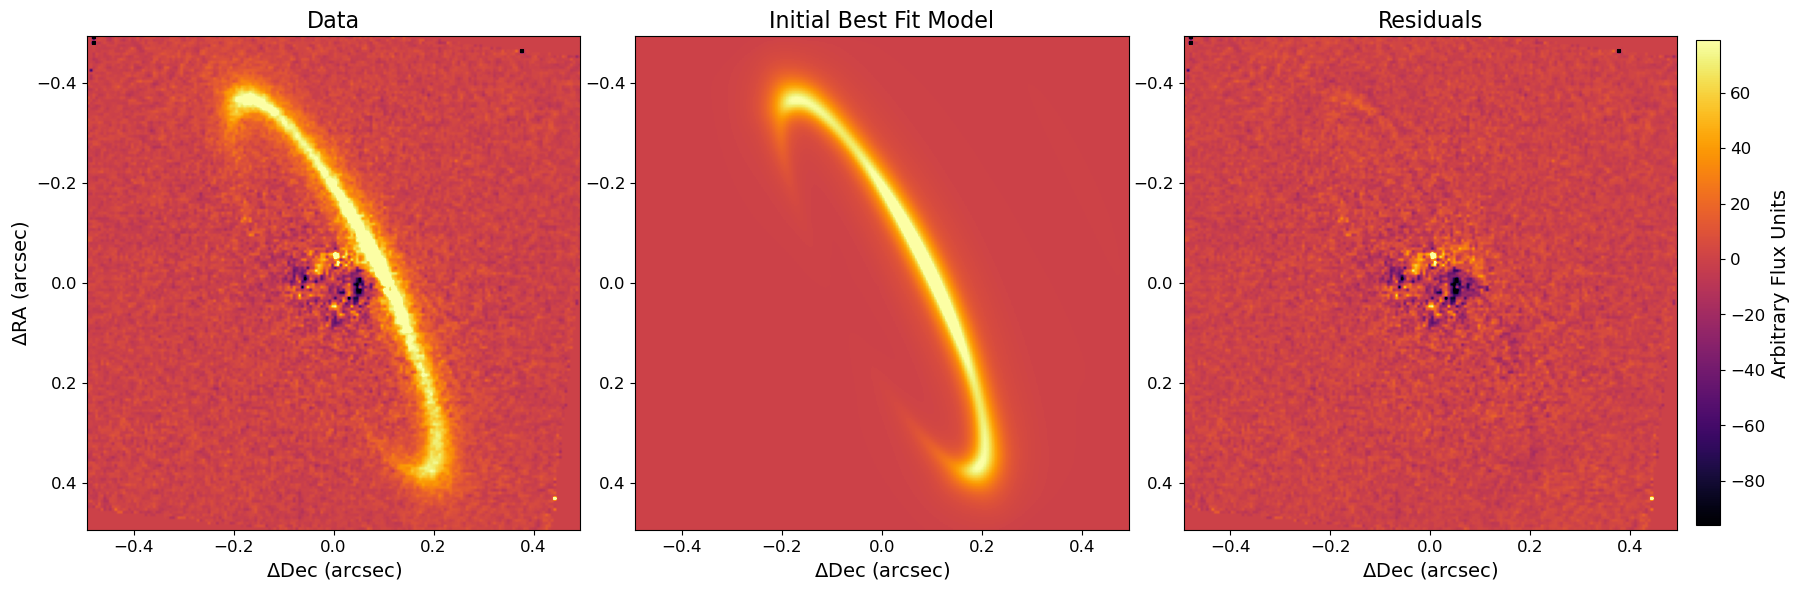

In [72]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("Initial Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=10)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_init_fit.png'.format(name))

166.5 13.50000000000001
[4.12106645e+00 1.97073836e+00 1.65738038e+00 1.12874343e+00
 1.00000000e+00 6.34393189e-01 5.01409408e-01 2.40206075e-01
 5.30503114e-05]


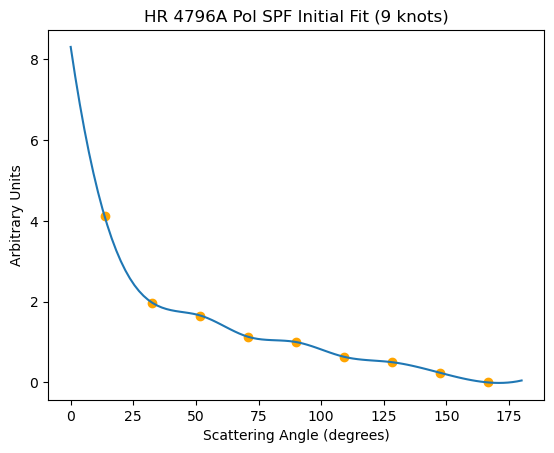

In [3]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['low_bound']))
lo = np.rad2deg(np.arccos(spf1['up_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func)
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange')

###CHANGE NAMES
plt.title('HR 4796A Pol SPF Initial Fit (9 knots)')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.savefig('../GPI_results/best_fits/hr4796a_pol_spf_init.png',bbox_inches='tight')

## MCMC Fit

In [97]:
bounds = ([0.1, -35, 0, 0,0.01,0.1,0.1,-20, 0, -20, 80, 80, 0, np.zeros(num_knots)],
          [35, -0.1, 150,1,0.35,0.6,15,380, 180, 380, 100, 100, 5e5, 1e4*np.ones(num_knots)])

opt.disk_params['e'] = 1e-5
opt.disk_params['omega'] = 1e-5
opt.disk_params['sma'] = 73

mc_model = opt.mcmc(fit_keys, target_image, err_map, bounds, nwalkers=100, niter=150, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Running production...


100%|██████████| 150/150 [01:34<00:00,  1.59it/s]


In [98]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()

In [99]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 34.17019599157464, 'alpha_out': -19.960448463275497, 'sma': 72.84232836189389, 'e': 0.0425588987920524, 'ksi0': 0.16746879581997964, 'gamma': 0.11003480950988838, 'beta': 9.530573916758428, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.35171915067836, 'position_angle': 26.556465319860546, 'x_center': 91.71152063654928, 'y_center': 90.58962874666798, 'halfNbSlices': 25, 'omega': -0.476814799753062}
SPF Params: {'low_bound': Array(-0.97236992, dtype=float64), 'up_bound': Array(0.97236992, dtype=float64), 'num_knots': 9, 'knot_values': array([3.19091470e+00, 2.44812431e+00, 2.10218919e+00, 1.17048393e+00,
       1.38346437e+00, 6.26425293e-01, 6.01308624e-01, 2.37198639e-01,
       1.62811638e-09])}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 180, 'ny': 180, 'halfNbSlices': 25, 'flux_scaling': 146989.7341614156}


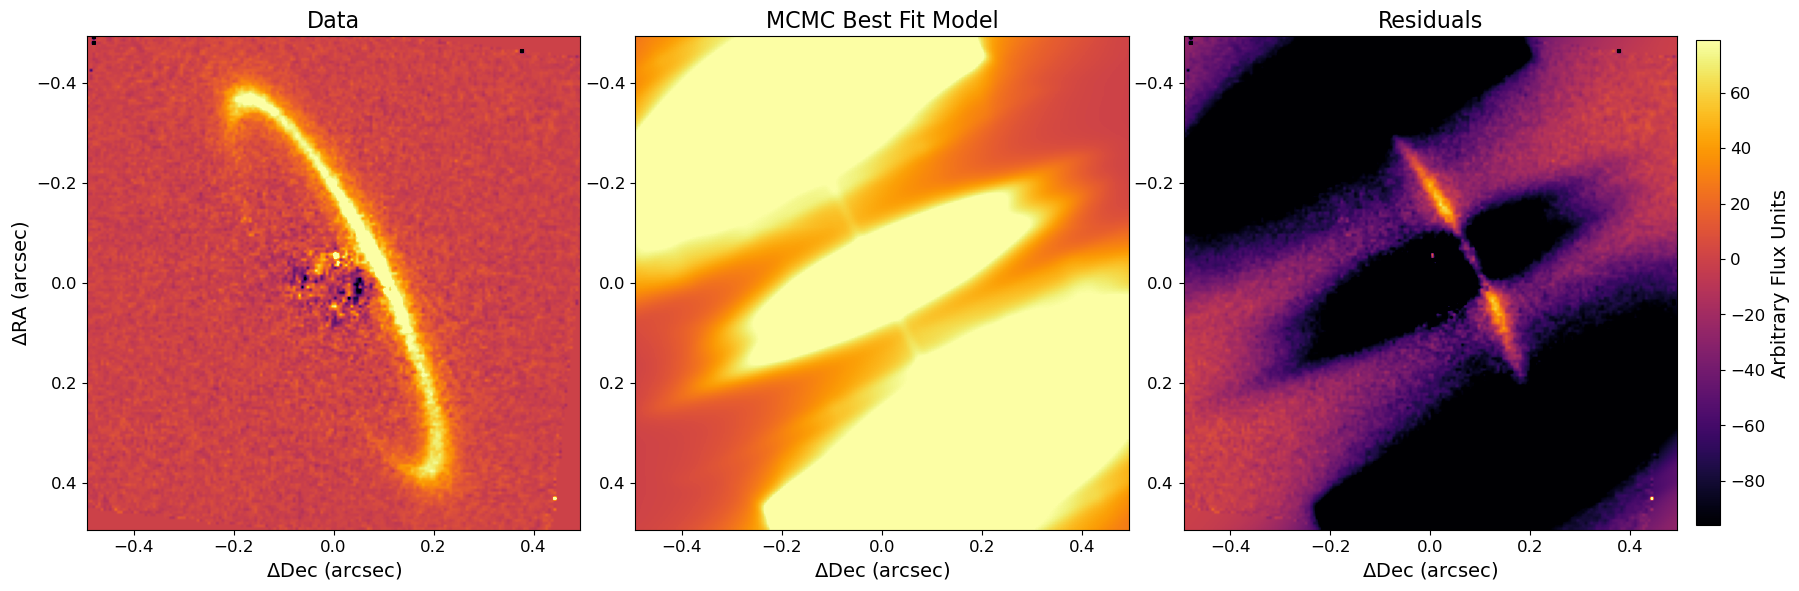

In [100]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("MCMC Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_MCMC_fit.png'.format(name))

In [92]:
#labels = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'omega', 'inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling']
#for i in range(0, opt.spf_params['num_knots']):
#    labels.append('k'+str(i+1))
#print(labels)
#mc_model.plot_chains(labels)

[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too

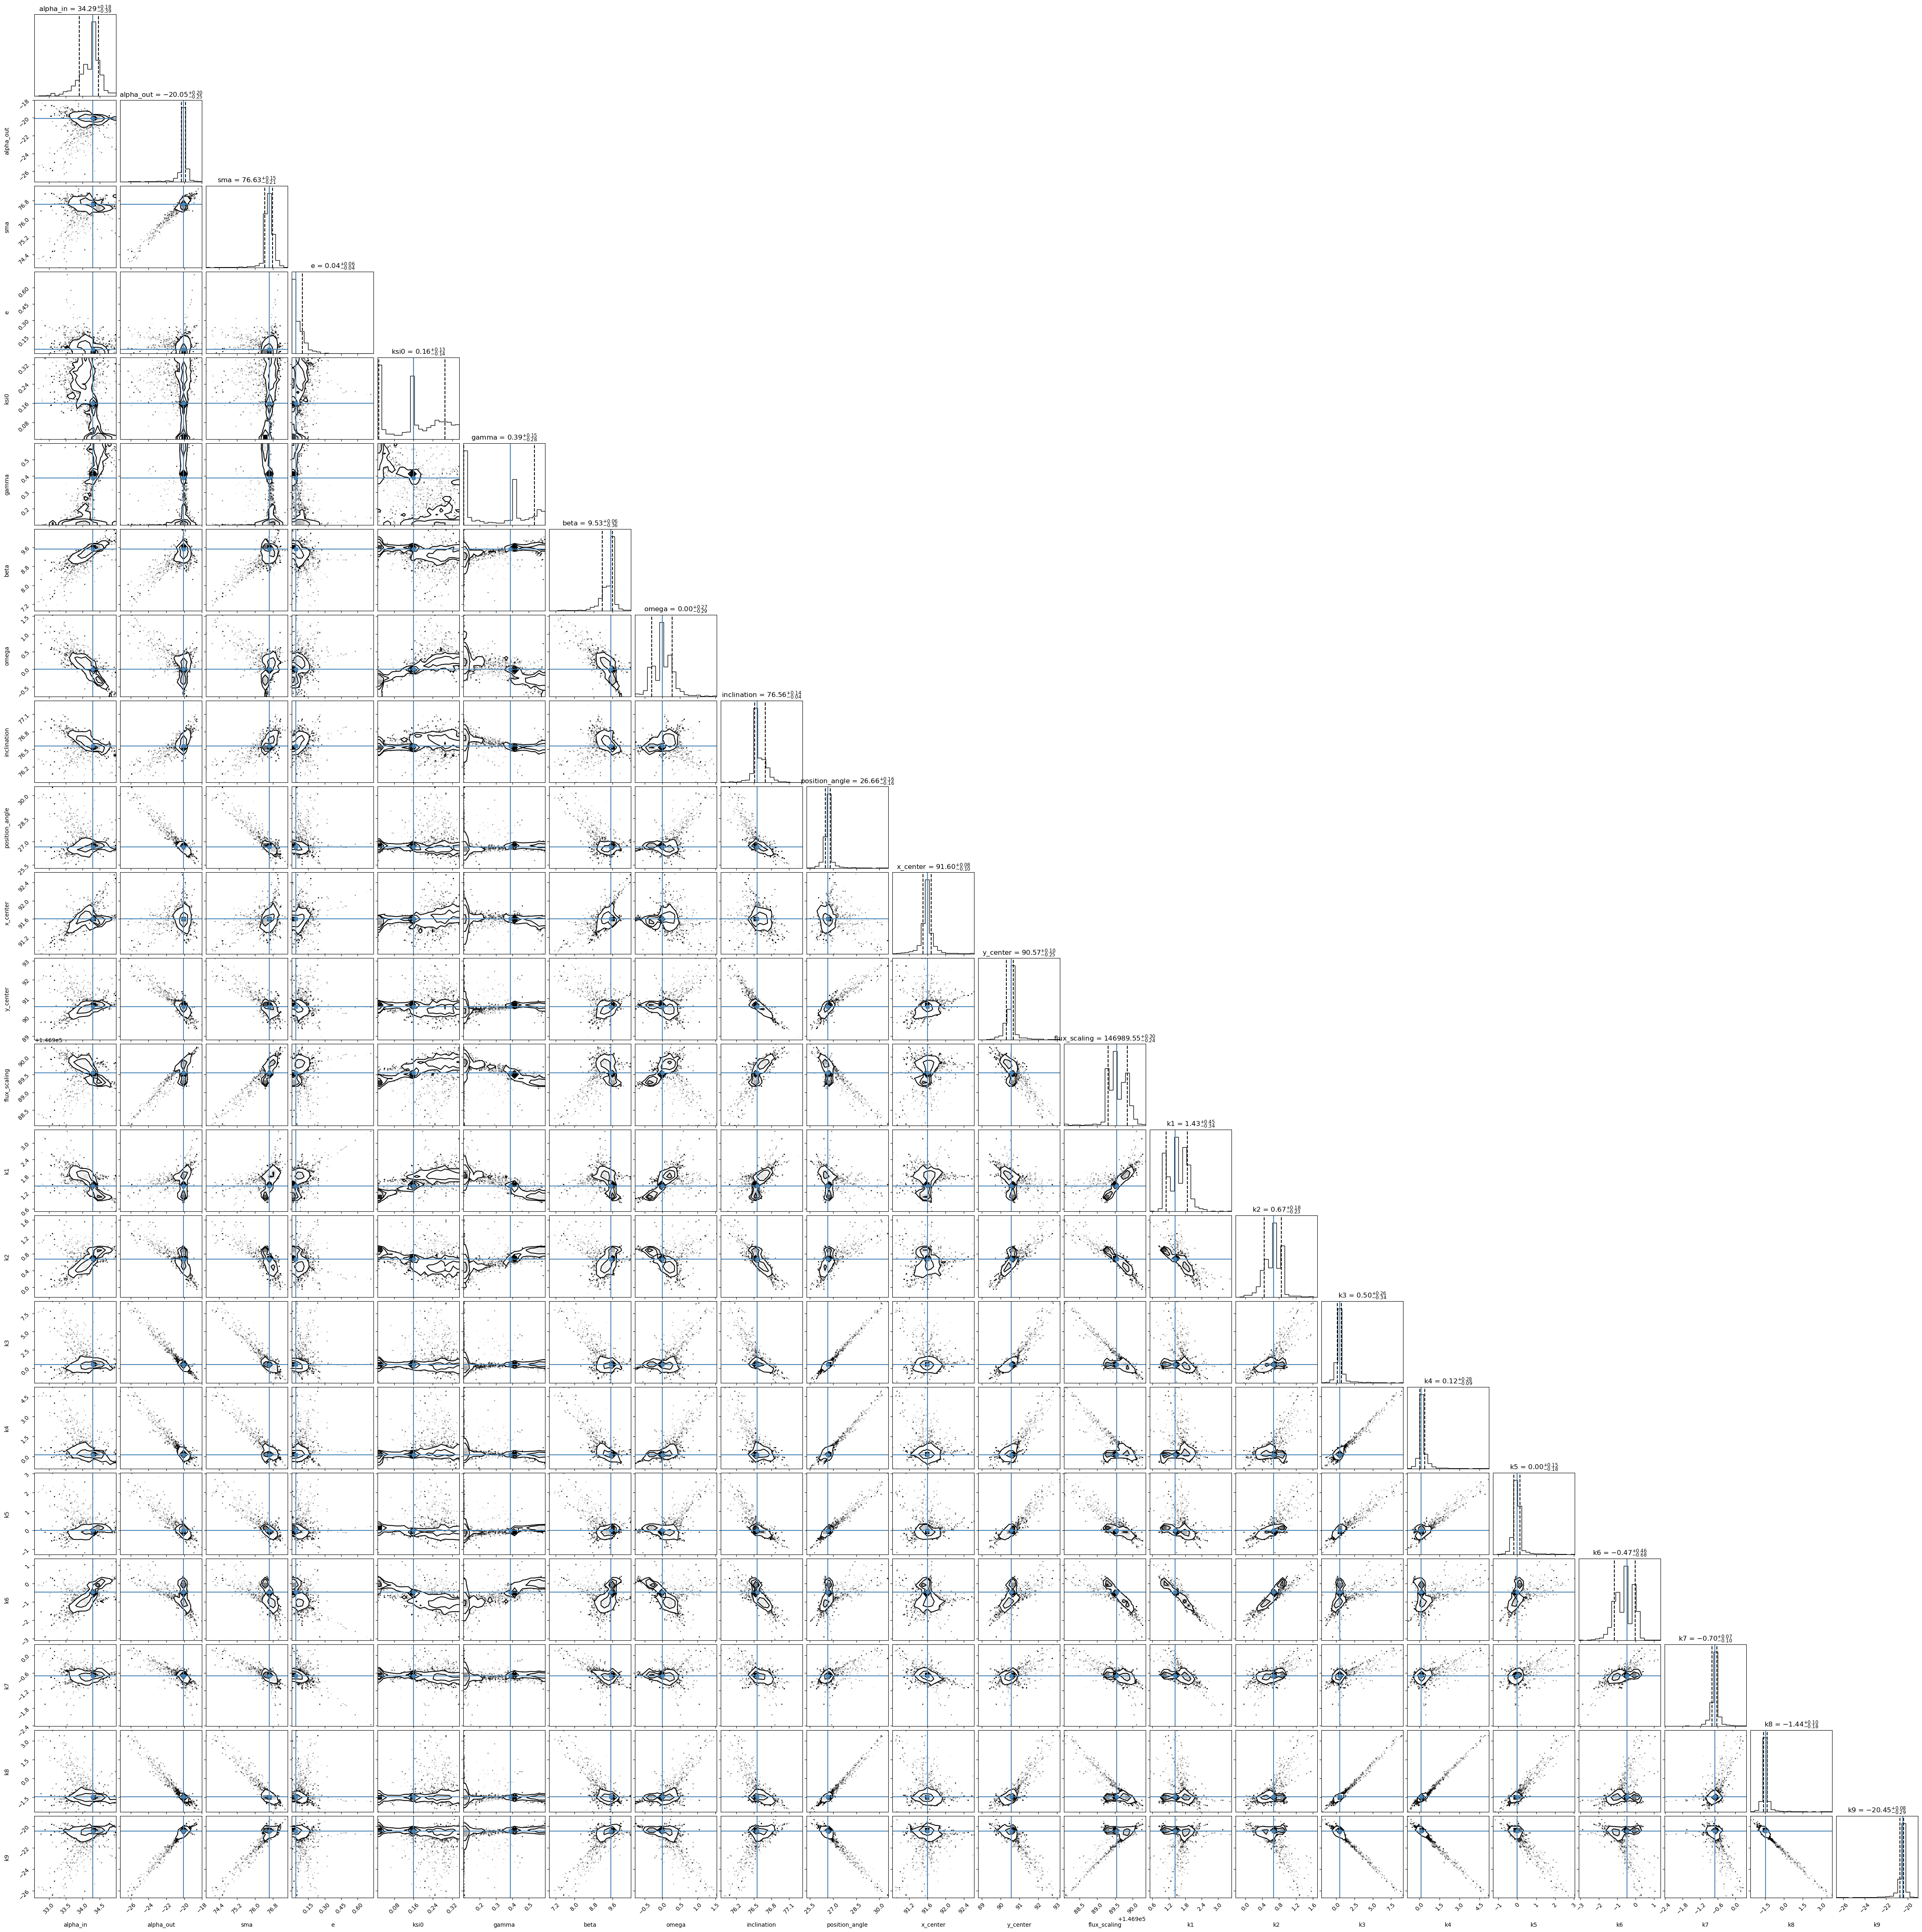

In [93]:
mc_model.show_corner_plot(labels, truths=mc_soln)

166.5 13.50000000000001


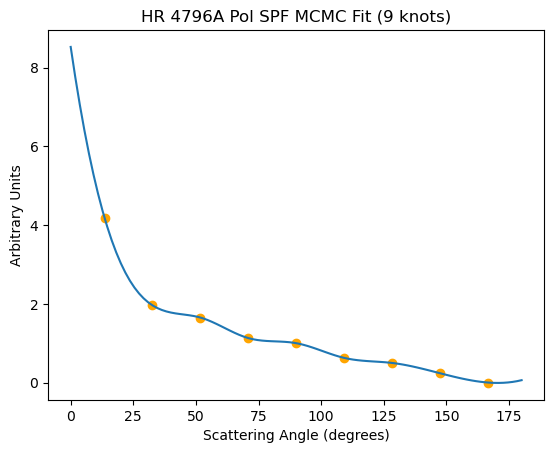

In [96]:
hi = np.rad2deg(np.arccos(opt.spf_params['low_bound']))
lo = np.rad2deg(np.arccos(opt.spf_params['up_bound']))
print(hi,lo)

spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,9),opt.spf_params['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func)
plt.scatter(np.linspace(lo,hi,9),opt.spf_params['knot_values'],color='orange')
plt.title('HR 4796A Pol SPF MCMC Fit (9 knots)')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.savefig('../GPI_results/best_fits/hr4796a_pol_spf_MCMC.png',bbox_inches='tight')